# 1. Import Modules

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from IPython.display import display

---

# 2. Load Data

In [9]:
df = pd.read_csv('./res/Persistent_vs_NonPersistent.csv')

# 

---

# 3. Preprocessing

In [10]:
df = df.drop(columns=['Ptid'])
y  = df['Persistency_Flag']
X  = df.drop(columns=['Persistency_Flag'])

cat_cols = X.select_dtypes(include=['object', 'category']).columns


# 4. One-hot encode those ONLY
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Scale numeric features
num_cols = X_train.select_dtypes(include='number').columns
scaler   = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test [num_cols] = scaler.transform(   X_test [num_cols])

---

# 4. Logistic Regression Baseline Model


In [11]:
log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train)
print("Logistic Regression Model")
print(classification_report(y_test, log.predict(X_test)))

Logistic Regression Model
                precision    recall  f1-score   support

Non-Persistent       0.82      0.87      0.84       427
    Persistent       0.76      0.69      0.72       258

      accuracy                           0.80       685
     macro avg       0.79      0.78      0.78       685
  weighted avg       0.80      0.80      0.80       685



---

# 5. KNN Hyperparameter Search

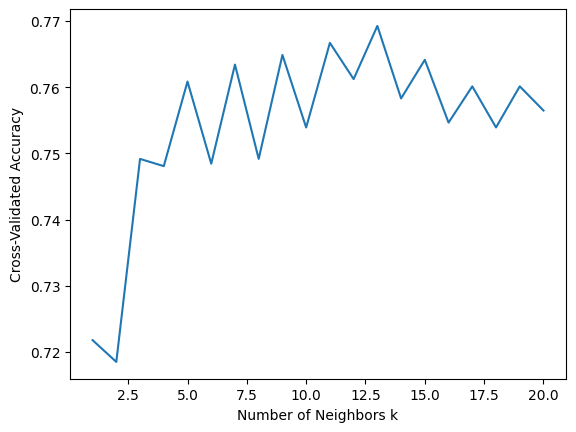

Optimal k = 13


In [12]:
k_range = range(1, 21)
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

plt.plot(k_range, cv_scores)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

best_k = k_range[np.argmax(cv_scores)]
print(f'Optimal k = {best_k}')

---

# 6. Train & Evaluate the Model

In [13]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
print('KNN Report:')
print(classification_report(y_test, knn.predict(X_test)))

KNN Report:
                precision    recall  f1-score   support

Non-Persistent       0.74      0.95      0.83       427
    Persistent       0.84      0.45      0.59       258

      accuracy                           0.76       685
     macro avg       0.79      0.70      0.71       685
  weighted avg       0.78      0.76      0.74       685



# Display Data

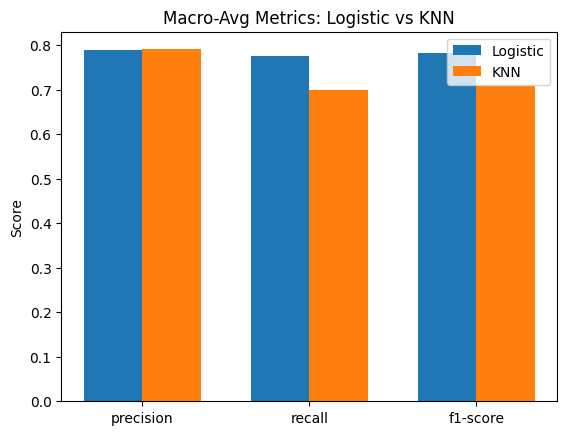

In [14]:
# Pick the metrics you care about
metrics = ['precision', 'recall', 'f1-score']

log_report = classification_report(y_test, log.predict(X_test), output_dict=True)
knn_report = classification_report(y_test, knn.predict(X_test), output_dict=True)

df_log = pd.DataFrame(log_report).T.add_prefix('Logistic_')
df_knn = pd.DataFrame(knn_report).T.add_prefix('KNN_')

df_comparison = pd.concat([df_log, df_knn], axis=1)

# Pull out the macro-avg values for each model
log_vals = [df_comparison.loc['macro avg', f'Logistic_{m}'] for m in metrics]
knn_vals = [df_comparison.loc['macro avg', f'KNN_{m}']      for m in metrics]

# X-axis positions
x = np.arange(len(metrics))
width = 0.35

plt.figure()
plt.bar(x - width/2, log_vals, width, label='Logistic')
plt.bar(x + width/2, knn_vals, width, label='KNN')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Macro-Avg Metrics: Logistic vs KNN')
plt.legend()

plt.show()
